In [22]:
import json
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import HDBSCAN 
from transformers import AutoTokenizer
from nltk.tokenize import sent_tokenize
from sentence_transformers import util
from sentence_transformers import SentenceTransformer

In [2]:
dir_root = "Data/"

In [75]:
with open(f"{dir_root}qaa.json","r") as f:
    data = json.load(f)
len(data)

18004

In [76]:
sentences = []
for item in tqdm(data):
    sentences += sent_tokenize(item["answare"])
data = pd.DataFrame({"sentence" : sentences})
data["sentences"] = data["sentence"].apply(lambda x: x.strip())
data["wc"] = data["sentence"].apply(lambda x: len(x.split(" ")))

100% 18004/18004 [00:01<00:00, 13107.43it/s]


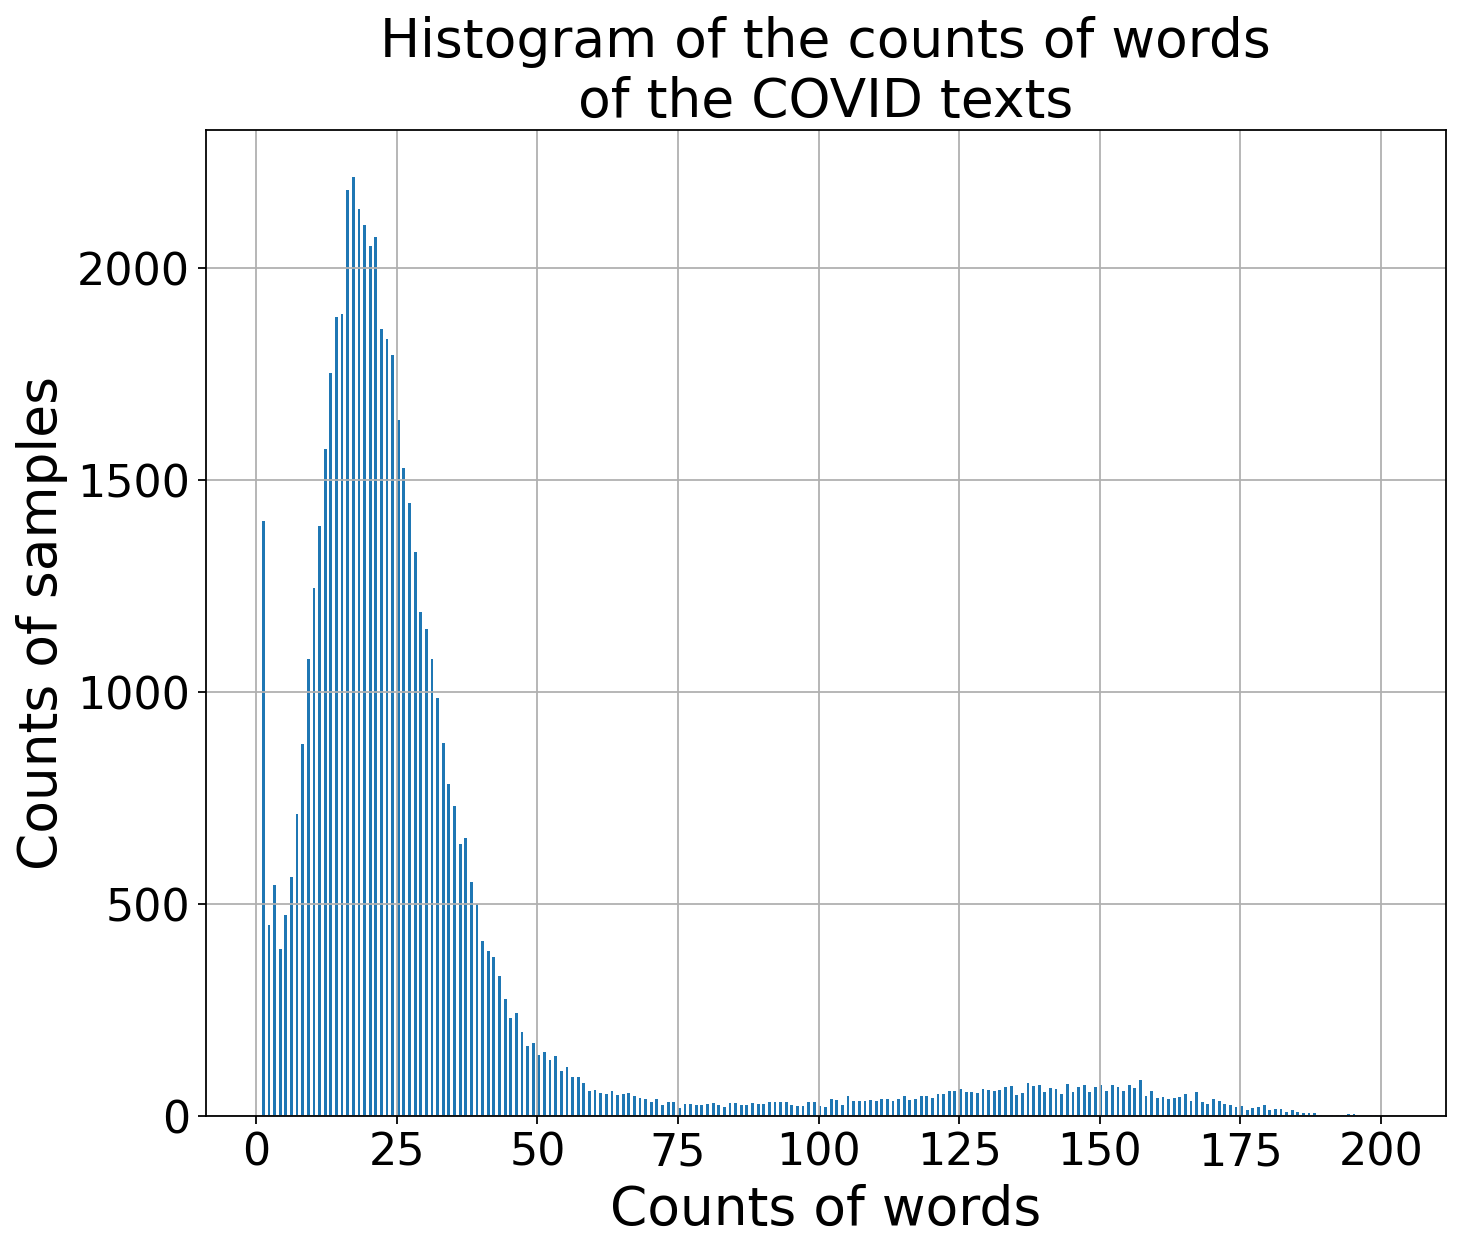

,wc
count,58713.000000
mean,30.962989
std,32.915420
min,1.000000
25%,15.000000
50%,22.000000
75%,32.000000
max,200.000000


In [77]:
plt.figure(figsize=(10, 8), dpi=160)
data["wc"].hist(bins=[i for i in np.arange(data["wc"].min(), data["wc"].max() + 2, 0.5)])
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Counts of words', fontsize=24)
plt.ylabel('Counts of samples', fontsize=24)
plt.title("Histogram of the counts of words\nof the COVID texts", fontsize=24)
plt.savefig('../images/wc_histogram_total_covid.png')
plt.show()
data.describe()

In [72]:
data = data[(data["wc"] >= 10) & (data["wc"] <= 30)]
data.reset_index()
data

,sentence,sentences,wc,D1,D2,labels
0,Our goal was to find out whether the data has ...,Our goal was to find out whether the data has ...,28,12.024868,2.420072,764
1,We then used a leave-one-out cross-validation ...,We then used a leave-one-out cross-validation ...,12,12.191805,2.269196,768
2,"In this classification task, we computed the F...","In this classification task, we computed the F...",16,12.274679,1.928792,717
3,We performed the Wald test to find the signifi...,We performed the Wald test to find the signifi...,21,11.527485,1.270256,830
4,Since the data had nine dimensions (from nine ...,Since the data had nine dimensions (from nine ...,17,10.867599,2.417719,382
...,...,...,...,...,...,...
8555,4 we plot a truncated logistic distribution fi...,4 we plot a truncated logistic distribution fi...,17,12.482182,0.049966,613
8556,In Section 2.1 we discussed how the combinatio...,In Section 2.1 we discussed how the combinatio...,27,13.158998,-0.933076,400
8557,"New York City, where confirmed cases substanti...","New York City, where confirmed cases substanti...",15,9.627542,-0.713459,787
8558,"Brendan K. Beare: Methodology, Formal Analysis...","Brendan K. Beare: Methodology, Formal Analysis...",10,1.543264,3.611542,21


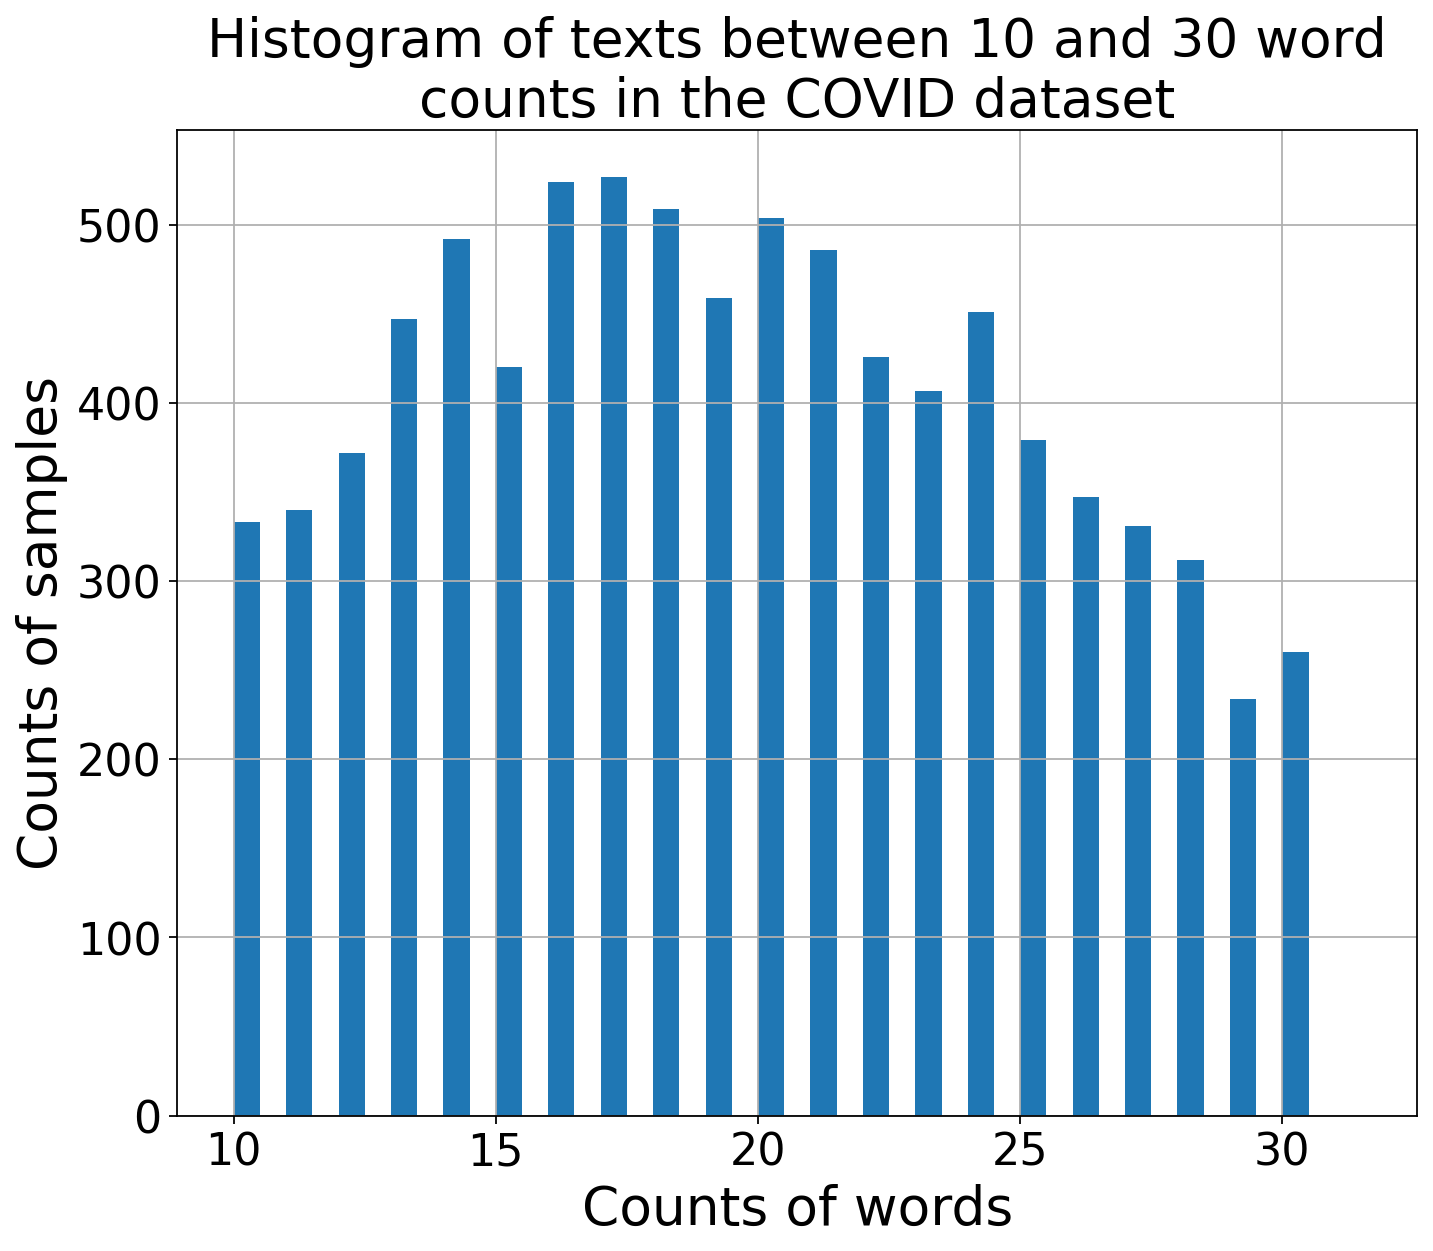

,wc,D1,D2,labels
count,8560.000000,8560.000000,8560.000000,8560.000000
mean,19.434346,10.072606,-0.270852,450.642523
std,5.551942,2.467194,2.596131,261.392691
min,10.000000,1.541833,-7.275213,1.000000
25%,15.000000,8.318701,-2.159399,225.000000
50%,19.000000,9.975928,-0.229886,450.000000
75%,24.000000,12.039338,1.632332,679.250000
max,30.000000,16.172544,6.799123,901.000000


In [73]:
plt.figure(figsize=(10, 8), dpi=160)
data["wc"].hist(bins=[i for i in np.arange(data["wc"].min(), data["wc"].max() + 2, 0.5)])
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Counts of words', fontsize=24)
plt.ylabel('Counts of samples', fontsize=24)
plt.title("Histogram of texts between 10 and 30 word\ncounts in the COVID dataset", fontsize=24)
plt.savefig('../images/wc_histogram_covid.png')
plt.show()
data.describe()

- https://maartengr.github.io/BERTopic/algorithm/algorithm.html#visual-overview
- https://scikit--learn-org.translate.goog/stable/modules/clustering.html?_x_tr_sl=en&_x_tr_tl=hu&_x_tr_hl=hu&_x_tr_pto=wapp
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

In [6]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/opt/conda/envs/SuperExpert/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
embbeded_vectors = model.encode(data["sentence"].values, show_progress_bar=True)

Batches:   0%|          | 0/1133 [00:00<?, ?it/s]

In [8]:
umapper = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')
umapper.fit(embbeded_vectors)
reduced = umapper.transform(embbeded_vectors)

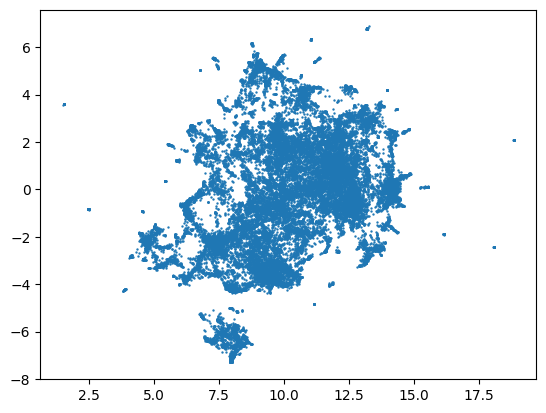

In [10]:
plt.scatter(reduced[:, 0], reduced[:, 1], s=0.5);

In [11]:
hdbs = HDBSCAN(min_cluster_size=6, max_cluster_size=15, metric='euclidean', cluster_selection_method='eom')
hdbs.fit(reduced)

HDBSCAN(max_cluster_size=15, min_cluster_size=6)

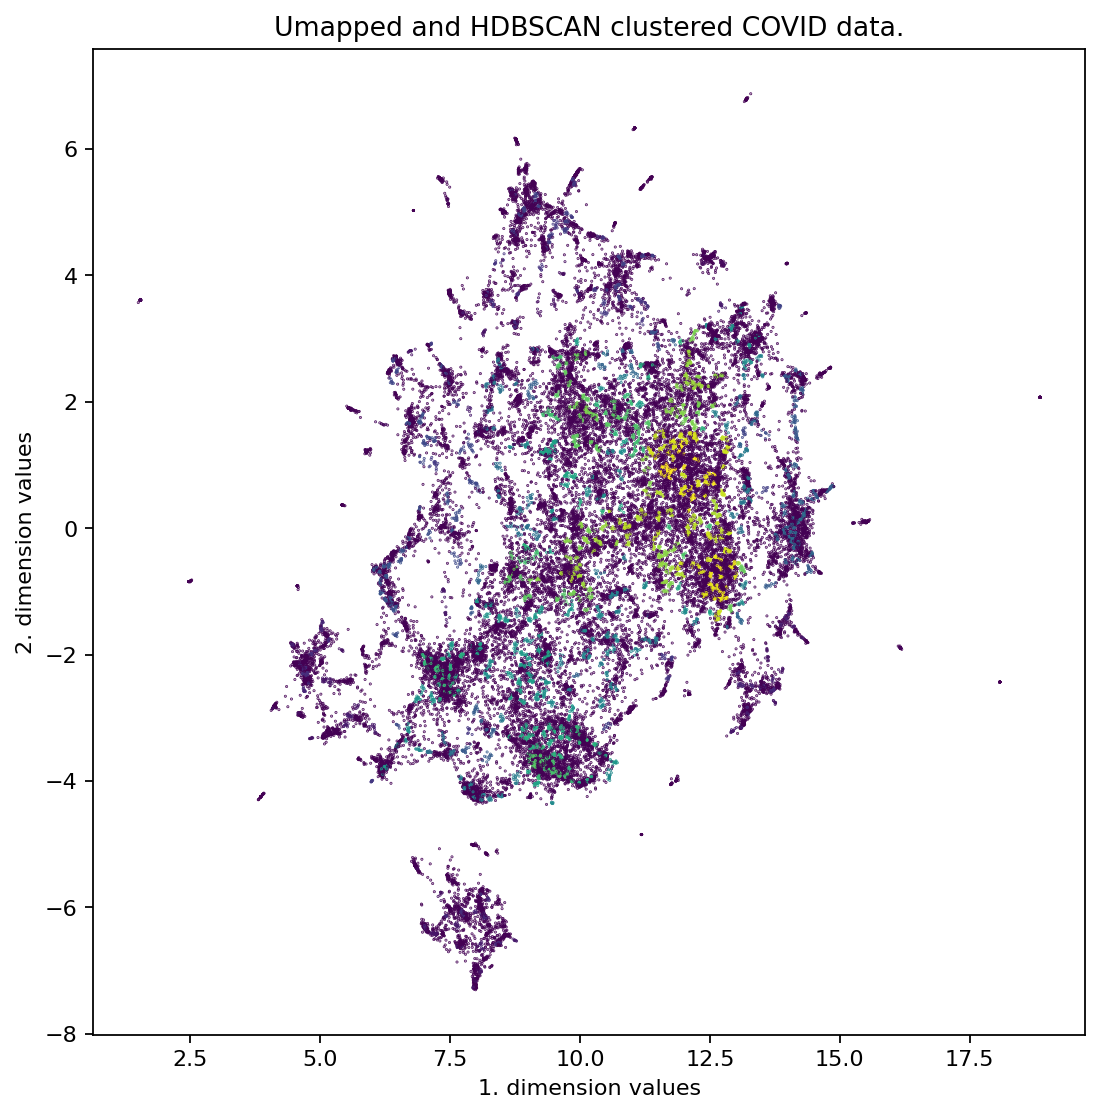

In [12]:
plt.figure(figsize=(8, 8), dpi=160)
plt.scatter(reduced[:, 0], reduced[:, 1], s=0.1, c=hdbs.labels_)
plt.title("Umapped and HDBSCAN clustered COVID data.")
plt.xlabel("1. dimension values")
plt.ylabel("2. dimension values")
plt.savefig('../images/umap_hdbscan_covid.png')

In [64]:
data["D1"] = reduced[:, 0]
data["D2"] = reduced[:, 1]
data["labels"] = hdbs.labels_
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Index: 36245 entries, 2 to 58712
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence   36245 non-null  object 
 1   sentences  36245 non-null  object 
 2   wc         36245 non-null  int64  
 3   D1         36245 non-null  float32
 4   D2         36245 non-null  float32
 5   labels     36245 non-null  int64  
dtypes: float32(2), int64(2), object(2)
memory usage: 1.7+ MB


,sentence,sentences,wc,D1,D2,labels
2,The participants without PD were recruited thr...,The participants without PD were recruited thr...,13,9.237181,1.249176,-1
4,The participants with PD were recruited by ema...,The participants with PD were recruited by ema...,28,7.784748,-0.108014,-1
5,All PD participants had some degree of PD symp...,All PD participants had some degree of PD symp...,18,7.728401,-0.107554,-1
7,We were interested in the muscle movements in ...,We were interested in the muscle movements in ...,18,8.681753,3.819175,-1
8,"In the past, researchers have looked into the ...","In the past, researchers have looked into the ...",15,8.681533,3.922916,-1
...,...,...,...,...,...,...
58707,While it may be natural to look for county-spe...,While it may be natural to look for county-spe...,25,10.052578,-0.277334,-1
58709,There is no need to attribute the highest case...,There is no need to attribute the highest case...,14,10.239251,-0.264784,-1
58710,"New York City, where confirmed cases substanti...","New York City, where confirmed cases substanti...",15,9.627542,-0.713459,787
58711,"Brendan K. Beare: Methodology, Formal Analysis...","Brendan K. Beare: Methodology, Formal Analysis...",10,1.543264,3.611542,21


In [65]:
data = data[data["labels"] > 0]
data = data.reset_index(drop=True)
data

,sentence,sentences,wc,D1,D2,labels
0,Our goal was to find out whether the data has ...,Our goal was to find out whether the data has ...,28,12.024868,2.420072,764
1,We then used a leave-one-out cross-validation ...,We then used a leave-one-out cross-validation ...,12,12.191805,2.269196,768
2,"In this classification task, we computed the F...","In this classification task, we computed the F...",16,12.274679,1.928792,717
3,We performed the Wald test to find the signifi...,We performed the Wald test to find the signifi...,21,11.527485,1.270256,830
4,Since the data had nine dimensions (from nine ...,Since the data had nine dimensions (from nine ...,17,10.867599,2.417719,382
...,...,...,...,...,...,...
8555,4 we plot a truncated logistic distribution fi...,4 we plot a truncated logistic distribution fi...,17,12.482182,0.049966,613
8556,In Section 2.1 we discussed how the combinatio...,In Section 2.1 we discussed how the combinatio...,27,13.158998,-0.933076,400
8557,"New York City, where confirmed cases substanti...","New York City, where confirmed cases substanti...",15,9.627542,-0.713459,787
8558,"Brendan K. Beare: Methodology, Formal Analysis...","Brendan K. Beare: Methodology, Formal Analysis...",10,1.543264,3.611542,21


In [66]:
topics = []
grouped_data = data.groupby(["labels"])
for k in tqdm(list(grouped_data.groups.keys())):
    topics.append(data.filter(items = grouped_data.groups[k], axis=0)["sentences"].values)

100% 901/901 [00:00<00:00, 3561.12it/s]


In [67]:
tokenizer_opt = AutoTokenizer.from_pretrained("facebook/opt-6.7b")
tokenizer_gptj = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer_llama = AutoTokenizer.from_pretrained("huggyllama/llama-7b")
tokenizer_llama2 = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

In [68]:
topics = pd.DataFrame({"text" : ["\n".join(t) for t in topics], "len" : [len(t) for t in topics]})
topics["words_count"] = [len(text.split(" ")) for text in topics["text"].values]
topics["t_opt_count"] = [len(tokenizer_opt(text,return_tensors="pt")["input_ids"][0]) for text in topics["text"].values]
topics["t_gptj_count"] = [len(tokenizer_gptj(text,return_tensors="pt")["input_ids"][0]) for text in topics["text"].values]
topics["t_llama_count"] = [len(tokenizer_llama(text,return_tensors="pt")["input_ids"][0]) for text in topics["text"].values]
topics["t_llama2_count"] = [len(tokenizer_llama2(text,return_tensors="pt")["input_ids"][0]) for text in topics["text"].values]
topics

,text,len,words_count,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count
0,All these issues can be resolved with the use ...,12,215,301,300,366,366
1,Two kinds of chimps with different autonomous ...,9,137,204,203,225,225
2,We show that the minimum sensor placement prob...,12,219,307,306,326,326
3,"At continuum level, the rules for constructing...",14,264,394,393,430,430
4,where x are instances of image-like structures...,6,118,174,173,180,180
...,...,...,...,...,...,...,...
896,We first introduce the mathematical formulatio...,15,293,453,452,486,486
897,"In particular, we have investigated the capabi...",12,234,310,309,336,336
898,Proper scoring rules [3] are today the standar...,7,134,177,176,197,197
899,We name our model epiABM and in this section w...,6,87,132,131,148,148


In [69]:
topics.describe()

,len,words_count,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count
count,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000
mean,9.500555,176.136515,262.732519,261.732519,292.694784,292.694784
std,2.823562,56.533060,101.940617,101.940617,110.060312,110.060312
min,6.000000,74.000000,97.000000,96.000000,109.000000,109.000000
25%,7.000000,132.000000,188.000000,187.000000,211.000000,211.000000
50%,9.000000,167.000000,243.000000,242.000000,271.000000,271.000000
75%,12.000000,214.000000,318.000000,317.000000,354.000000,354.000000
max,15.000000,344.000000,1261.000000,1260.000000,1271.000000,1271.000000


In [70]:
topics = topics[topics["t_llama2_count"] <= 256]
topics = topics.reset_index(drop=True)
topics.describe()

,len,words_count,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,7.203980,128.527363,181.743781,180.743781,202.154229,202.154229
std,1.201904,20.942041,29.315661,29.315661,32.736858,32.736858
min,6.000000,74.000000,97.000000,96.000000,109.000000,109.000000
25%,6.000000,113.000000,160.000000,159.000000,179.000000,179.000000
50%,7.000000,129.000000,182.000000,181.000000,204.000000,204.000000
75%,8.000000,144.000000,204.000000,203.000000,227.750000,227.750000
max,12.000000,186.000000,242.000000,241.000000,256.000000,256.000000


In [21]:
topics[["text"]]

,text
0,SCs are typically presented as smartphone chat...
1,We show that the minimum sensor placement prob...
2,This assumption has a long history in populati...
3,Movies were recorded with a Camera (Sony® FDR ...
4,"David Lambert: Formal analysis, Data curation,..."
...,...
307,The methods and systems we put forward here co...
308,"However, we noticed that it depends on the val..."
309,The network from which SVA metrics are calcula...
310,"In Section Conclusions and future work, we mak..."


In [22]:
topics[["text"]].to_csv(f"{dir_root}topic.csv")
topics

,text,len,words_count,t_opt_count,t_gptj_count,t_llama_count,t_llama2_count
0,SCs are typically presented as smartphone chat...,7,131,180,179,205,205
1,We show that the minimum sensor placement prob...,9,173,229,228,246,246
2,This assumption has a long history in populati...,6,101,137,136,155,155
3,Movies were recorded with a Camera (Sony® FDR ...,6,109,151,150,172,172
4,"David Lambert: Formal analysis, Data curation,...",8,100,229,228,245,245
...,...,...,...,...,...,...,...
307,The methods and systems we put forward here co...,6,85,106,105,111,111
308,"However, we noticed that it depends on the val...",7,114,181,180,192,192
309,The network from which SVA metrics are calcula...,8,158,226,225,240,240
310,"In Section Conclusions and future work, we mak...",6,77,101,100,111,111


In [23]:
pd.read_csv(f"{dir_root}topic.csv")

,Unnamed: 0,text
0,0,SCs are typically presented as smartphone chat...
1,1,We show that the minimum sensor placement prob...
2,2,This assumption has a long history in populati...
3,3,Movies were recorded with a Camera (Sony® FDR ...
4,4,"David Lambert: Formal analysis, Data curation,..."
...,...,...
307,307,The methods and systems we put forward here co...
308,308,"However, we noticed that it depends on the val..."
309,309,The network from which SVA metrics are calcula...
310,310,"In Section Conclusions and future work, we mak..."
